In [2]:
"""
Extended Kalman Filter SLAM example
original author: Atsushi Sakai (@Atsushi_twi)
notebook author: Andrew Tu (drewtu2)
"""

import math
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt


# EKF state covariance
Cx = np.diag([0.5, 0.5, np.deg2rad(30.0)])**2 # Change in covariance

#  Simulation parameter
Qsim = np.diag([0.2, np.deg2rad(5.0)])**2  # Sensor Noise
Rsim = np.diag([1.0, np.deg2rad(10.0)])**2 # Process Noise

DT = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]
MAX_RANGE = 20.0  # maximum observation range
M_DIST_TH = 2.0  # Threshold of Mahalanobis distance for data association.
STATE_SIZE = 3  # State size [x,y,yaw]
LM_SIZE = 2  # Landmark state size [x,y]

show_animation = True
print('Cx = ', Cx, '\n Qsim = ', Qsim, '\n Rsim = ', Rsim)

Cx =  [[0.25       0.         0.        ]
 [0.         0.25       0.        ]
 [0.         0.         0.27415568]] 
 Qsim =  [[0.04       0.        ]
 [0.         0.00761544]] 
 Rsim =  [[1.         0.        ]
 [0.         0.03046174]]


In [3]:
def ekf_slam(xEst, PEst, u, z):
    """
    Performs an iteration of EKF SLAM from the available information.

    :param xEst: the belief in last position
    :param PEst: the uncertainty in last position
    :param u:    the control function applied to the last position
    :param z:    measurements at this step
    :returns:    the next estimated position and associated covariance
    """
    S = STATE_SIZE

    # Predict
    xEst, PEst, G, Fx = predict(xEst, PEst, u)
    initP = np.eye(2)

    # Update
    xEst, PEst = update(xEst, PEst, u, z, initP)

    return xEst, PEst

In [4]:
def predict(xEst, PEst, u):
    """
    Performs the prediction step of EKF SLAM

    :param xEst: n x 1 state vector
    :param PEst: n x n covariance matrix
    :param u:    2 x 1 control vector
    :returns:    predicted state vector, predicted covariance, jacobian of control vector, transition fx
    """
    S = STATE_SIZE # = 3
    G, Fx = jacob_motion(xEst[0:S], u)
    xEst[0:S] = motion_model(xEst[0:S], u)
    # Fx is an an identity matrix of size (STATE_SIZE)
    # sigma = G*sigma*G.T + Noise
    PEst[0:S, 0:S] = G.T @ PEst[0:S, 0:S] @ G + Fx.T @ Cx @ Fx
    return xEst, PEst, G, Fx

In [14]:
def motion_model(x, u):
    """
    Computes the motion model based on current state and input function.

    :param x: 3x1 pose estimation
    :param u: 2x1 control input [v; w]
    :returns: the resulting state after the control function is applied
    """
    F = np.array([[1.0, 0, 0],
                  [0, 1.0, 0],
                  [0, 0, 1.0]])

    B = np.array([[DT * math.cos(x[1, 0]), 0],
                  [DT * math.sin(x[1, 0]), 0],
                  [0.0, DT]])

    x = (F @ x) + (B @ u)
    return x

In [6]:
def update(xEst, PEst, u, z, initP):
    """
    Performs the update step of EKF SLAM

    :param xEst:  nx1 the predicted pose of the system and the pose of the landmarks
    :param PEst:  nxn the predicted covariance
    :param u:     2x1 the control function
    :param z:     the measurements read at new position
    :param initP: 2x2 an identity matrix acting as the initial covariance
    :returns:     the updated state and covariance for the system
    """
    for iz in range(len(z[:, 0])):  # for each observation
        minid = search_correspond_LM_ID(xEst, PEst, z[iz, 0:2]) # associate to a known landmark

        nLM = calc_n_LM(xEst) # number of landmarks we currently know about

        if minid == nLM: # Landmark is a NEW landmark
            print("New LM")
            # Extend state and covariance matrix
            xAug = np.vstack((xEst, calc_LM_Pos(xEst, z[iz, :])))
            PAug = np.vstack((np.hstack((PEst, np.zeros((len(xEst), LM_SIZE)))),
                              np.hstack((np.zeros((LM_SIZE, len(xEst))), initP))))
            xEst = xAug
            PEst = PAug

        lm = get_LM_Pos_from_state(xEst, minid)
        y, S, H = calc_innovation(lm, xEst, PEst, z[iz, 0:2], minid)

        K = (PEst @ H.T) @ np.linalg.inv(S) # Calculate Kalman Gain
        xEst = xEst + (K @ y)
        PEst = (np.eye(len(xEst)) - (K @ H)) @ PEst

    xEst[2] = pi_2_pi(xEst[2])
    return xEst, PEst

In [7]:
def calc_innovation(lm, xEst, PEst, z, LMid):
    """
    Calculates the innovation based on expected position and landmark position

    :param lm:   landmark position
    :param xEst: estimated position/state
    :param PEst: estimated covariance
    :param z:    read measurements
    :param LMid: landmark id
    :returns:    returns the innovation y, and the jacobian H, and S, used to calculate the Kalman Gain
    """
    delta = lm - xEst[0:2]
    q = (delta.T @ delta)[0, 0]
    zangle = math.atan2(delta[1, 0], delta[0, 0]) - xEst[2, 0]
    zp = np.array([[math.sqrt(q), pi_2_pi(zangle)]])
    # zp is the expected measurement based on xEst and the expected landmark position

    y = (z - zp).T # y = innovation
    y[1] = pi_2_pi(y[1])

    H = jacobH(q, delta, xEst, LMid + 1)
    S = H @ PEst @ H.T + Cx[0:2, 0:2]

    return y, S, H

def jacobH(q, delta, x, i):
    """
    Calculates the jacobian of the measurement function

    :param q:     the range from the system pose to the landmark
    :param delta: the difference between a landmark position and the estimated system position
    :param x:     the state, including the estimated system position
    :param i:     landmark id + 1
    :returns:     the jacobian H
    """
    sq = math.sqrt(q)
    G = np.array([[-sq * delta[0, 0], - sq * delta[1, 0], 0, sq * delta[0, 0], sq * delta[1, 0]],
                  [delta[1, 0], - delta[0, 0], - q, - delta[1, 0], delta[0, 0]]])

    G = G / q
    nLM = calc_n_LM(x)
    F1 = np.hstack((np.eye(3), np.zeros((3, 2 * nLM))))
    F2 = np.hstack((np.zeros((2, 3)), np.zeros((2, 2 * (i - 1))),
                    np.eye(2), np.zeros((2, 2 * nLM - 2 * i))))

    F = np.vstack((F1, F2))

    H = G @ F

    return H

In [8]:
def observation(xTrue, xd, u, RFID):
    """
    :param xTrue: the true pose of the system
    :param xd:    the current noisy estimate of the system
    :param u:     the current control input
    :param RFID:  the true position of the landmarks

    :returns:     Computes the true position, observations, dead reckoning (noisy) position,
                  and noisy control function
    """
    xTrue = motion_model(xTrue, u)

    # add noise to gps x-y
    z = np.zeros((0, 3))

    for i in range(len(RFID[:, 0])): # Test all beacons, only add the ones we can see (within MAX_RANGE)

        dx = RFID[i, 0] - xTrue[0, 0]
        dy = RFID[i, 1] - xTrue[1, 0]
        d = math.sqrt(dx**2 + dy**2)
        angle = pi_2_pi(math.atan2(dy, dx) - xTrue[2, 0])
        if d <= MAX_RANGE:
            dn = d + np.random.randn() * Qsim[0, 0]  # add noise
            anglen = angle + np.random.randn() * Qsim[1, 1]  # add noise
            zi = np.array([dn, anglen, i])
            z = np.vstack((z, zi))

    # add noise to input
    ud = np.array([[
        u[0, 0] + np.random.randn() * Rsim[0, 0],
        u[1, 0] + np.random.randn() * Rsim[1, 1]]]).T

    xd = motion_model(xd, ud)
    return xTrue, z, xd, ud

In [9]:
def calc_n_LM(x):
    """
    Calculates the number of landmarks currently tracked in the state
    :param x: the state
    :returns: the number of landmarks n
    """
    n = int((len(x) - STATE_SIZE) / LM_SIZE)
    return n


def jacob_motion(x, u):
    """
    Calculates the jacobian of motion model.

    :param x: The state, including the estimated position of the system
    :param u: The control function
    :returns: G:  Jacobian
              Fx: STATE_SIZE x (STATE_SIZE + 2 * num_landmarks) matrix 
              where the left side is an identity matrix
    """

    # [eye(3) [0 x y; 0 x y; 0 x y]]
    Fx = np.hstack((np.eye(STATE_SIZE), np.zeros(
        (STATE_SIZE, LM_SIZE * calc_n_LM(x)))))

    jF = np.array([[0.0, 0.0, -DT * u[0] * math.sin(x[2, 0])],
                   [0.0, 0.0, DT * u[0] * math.cos(x[2, 0])],
                   [0.0, 0.0, 0.0]],dtype=object)

    G = np.eye(STATE_SIZE) + Fx.T @ jF @ Fx
    if calc_n_LM(x) > 0:
        print(Fx.shape)
    return G, Fx,

In [12]:
def calc_LM_Pos(x, z):
    """
    Calculates the pose in the world coordinate frame of a landmark at the given measurement.

    :param x: [x; y; theta]
    :param z: [range; bearing]
    :returns: [x; y] for given measurement
    """
    zp = np.zeros((2, 1))

    zp[0, 0] = x[0, 0] + z[0] * math.cos(x[2, 0] + z[1])
    zp[1, 0] = x[1, 0] + z[0] * math.sin(x[2, 0] + z[1])
    #zp[0, 0] = x[0, 0] + z[0, 0] * math.cos(x[2, 0] + z[0, 1])
    #zp[1, 0] = x[1, 0] + z[0, 0] * math.sin(x[2, 0] + z[0, 1])

    return zp


def get_LM_Pos_from_state(x, ind):
    """
    Returns the position of a given landmark

    :param x:   The state containing all landmark positions
    :param ind: landmark id
    :returns:   The position of the landmark
    """
    lm = x[STATE_SIZE + LM_SIZE * ind: STATE_SIZE + LM_SIZE * (ind + 1), :]

    return lm


def search_correspond_LM_ID(xAug, PAug, zi):
    """
    Landmark association with Mahalanobis distance.

    If this landmark is at least M_DIST_TH units away from all known landmarks,
    it is a NEW landmark.

    :param xAug: The estimated state
    :param PAug: The estimated covariance
    :param zi:   the read measurements of specific landmark
    :returns:    landmark id
    """

    nLM = calc_n_LM(xAug)

    mdist = []

    for i in range(nLM):
        lm = get_LM_Pos_from_state(xAug, i)
        y, S, H = calc_innovation(lm, xAug, PAug, zi, i)
        mdist.append(y.T @ np.linalg.inv(S) @ y)

    mdist.append(M_DIST_TH)  # new landmark

    minid = mdist.index(min(mdist))

    return minid

def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.array([[v, yawrate]]).T
    print(u)
    return u

def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi

def main():
    print(" start!!")

    time = 0.0

    # RFID positions [x, y]
    RFID = np.array([[5.0, -5.0],
                     [15.0, 10.0],
                     [3.0, 15.0],
                     [-5.0, 20.0],
                     [-7.0, 10.0]])
    #RFID = np.array([[10.0, -2.0],
    #                 [15.0, 10.0],
    #                 [3.0, 15.0],
    #                 [-5.0, 20.0]])

    # State Vector [x y yaw v]'
    xEst = np.zeros((STATE_SIZE, 1))
    xTrue = np.zeros((STATE_SIZE, 1))
    PEst = np.eye(STATE_SIZE)

    xDR = np.zeros((STATE_SIZE, 1))  # Dead reckoning

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue

    while SIM_TIME >= time:
        time += DT
        u = calc_input()

        xTrue, z, xDR, ud = observation(xTrue, xDR, u, RFID)

        xEst, PEst = ekf_slam(xEst, PEst, ud, z)

        x_state = xEst[0:STATE_SIZE]

        # store data history
        hxEst = np.hstack((hxEst, x_state))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))

        if show_animation:  # pragma: no cover
            plt.cla()

            plt.plot(RFID[:, 0], RFID[:, 1], "*k")
            plt.plot(xEst[0], xEst[1], ".r")

            # plot landmark
            for i in range(calc_n_LM(xEst)):
                plt.plot(xEst[STATE_SIZE + i * 2],
                         xEst[STATE_SIZE + i * 2 + 1], "xg")

            plt.plot(hxTrue[0, :],
                     hxTrue[1, :], "-b")
            plt.plot(hxDR[0, :],
                     hxDR[1, :], "-k")
            plt.plot(hxEst[0, :],
                     hxEst[1, :], "-r")
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.001)

 start!!
[[1. ]
 [0.1]]
New LM
New LM
New LM
New LM


<IPython.core.display.Javascript object>


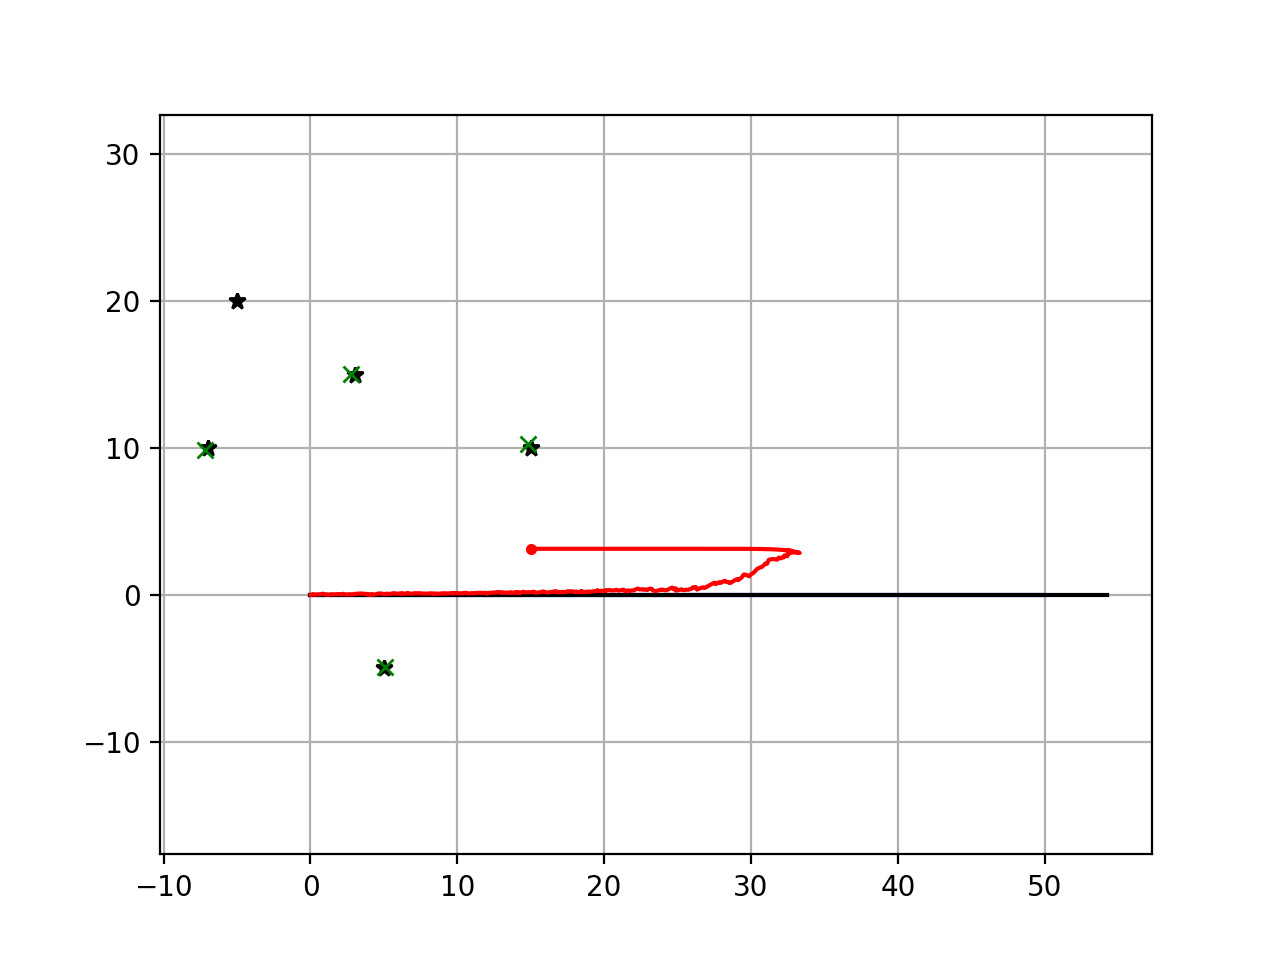

[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0.1]]
[[1. ]
 [0

In [15]:
%matplotlib notebook
main()